In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report

## Importing part

In [ ]:
train = pd.read_csv('train_ctrUa4K.csv')
test = pd.read_csv('test_lAUu6dG.csv')
sample_submission = pd.read_csv('sample_submission_49d68Cx.csv')

target = train['Loan_Status']
train.drop(['Loan_Status'], axis=1, inplace=True)

idx = len(train)

In [ ]:
train_num = train.select_dtypes(np.number)
test_num = test.select_dtypes(np.number)
num = pd.concat([train_num, test_num], axis=0).reset_index(drop=True)

train_cat = train.select_dtypes(include='object')
test_cat = test.select_dtypes(include='object')
cat = pd.concat([train_cat, test_cat], axis=0).reset_index(drop=True)

## Feature engineering

In [697]:
num_tr = num.copy()
cat_tr = cat.copy()

**Перед заполением нулей избавимся от выбросов в числовых признаках**

In [717]:
for col in ['ApplicantIncome', 'LoanAmount']:

      Q1 = np.nanpercentile(num_tr[col], 25)
      Q3 = np.nanpercentile(num_tr[col], 75)
      IQR = Q3 - Q1
      
      num_tr['{}_Outliers'.format(col)] = num_tr[col].map(lambda x: 'Normal' if x <= Q3 + 1.5 * IQR else 'Outlier') 
      # # temp[col > Q3 + 1.5 * IQR].groupby(col).mean()['Loan_Status']
      # print(temp[temp[col] > Q3 + 1.5 * IQR]['Loan_Status'].mean())

num_tr['CoapplicantIncome_Outliers'] = num_tr['CoapplicantIncome'].map(lambda x: 'Normal' if x <= 6700 else 'Outlier')

**Заполнение нулей**

In [718]:
num_tr['LoanAmount'] = num_tr['LoanAmount'].fillna(num_tr['LoanAmount'].mean())
num_tr['Loan_Amount_Term'] = num_tr['Loan_Amount_Term'].fillna(360.00)

#Знаю, что плохо, но это временно 
num_tr['Credit_History'] = num_tr['Credit_History'].fillna(0.5)

In [719]:
#Cat dummies - временная, дальше исп не будут
#В целом все действия тут нужны, чтобы предсказать только пропущеную кредитную историю
#Тут хитро: 
#         -> LoanAmount, 
#         потом уже с LoanAmount -> Credit_History

for col in ['Gender', 'Married', 'Dependents', 'Education',
            'Self_Employed', 'Property_Area']:
  cat[col] = cat[col].fillna(cat[col].mode()[0])


cat_dummies = pd.DataFrame()
for col in ['Gender', 'Married', 'Dependents', 'Education',
            'Self_Employed', 'Property_Area']:
  cat_dummies = pd.concat([cat_dummies, pd.get_dummies(data=cat[col], drop_first=True, prefix=col)], axis=1)

for col in ['ApplicantIncome_Outliers', 'CoapplicantIncome_Outliers', 'LoanAmount_Outliers']:
  cat_dummies = pd.concat([cat_dummies, pd.get_dummies(data=num_tr[col], drop_first=True, prefix=col)], axis=1)


X_ch = pd.concat([num_tr.drop(['ApplicantIncome_Outliers', 'CoapplicantIncome_Outliers', 'LoanAmount_Outliers'], axis=1), cat_dummies], axis=1)
X_ch = pd.DataFrame(data=sc.fit_transform(X_ch), columns=X_ch.columns)




rf = RandomForestClassifier(n_estimators=100, 
                            max_features=6, oob_score=True)

rf.fit(X_ch.iloc[:idx, :], target.map({'Y': 0, 'N': 1}))
X_ch['Loan_Status_temp'] = np.hstack((target.map({'Y': 0, 'N': 1}), rf.predict(X_ch.iloc[idx:, :])))



RS=4

ch = X_ch['Credit_History']
X_ch = X_ch.drop(['Credit_History'], axis=1)

ch_to_train_test =  ch[ch!=0.5]
X_ch_to_train_test =  X_ch[ch!=0.5]


knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_ch_to_train_test, ch_to_train_test);


X_ch['Credit_History'] = ch
X_ch['Credit_History'][X_ch['Credit_History'] == 0.5] = knn.predict(X_ch.drop(['Credit_History'], axis=1))

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [720]:
#Finally
num_tr['Credit_History'] = X_ch['Credit_History']

**"Настоящее" заполнение нулей для категориональных**

In [721]:
for col in ['Gender', 'Married', 'Dependents', 'Education',
            'Self_Employed', 'Property_Area']:
  cat_tr[col] = cat_tr[col].fillna(cat_tr[col].mode()[0])

**Соединяем числовые и тренировочные фичи**

In [722]:
all_data_tr = pd.concat([num_tr, cat_tr], axis=1)

**Теперь генерим фичи**

In [723]:
all_data_tr['Group_Loan_Amount_Term'] = all_data_tr['Loan_Amount_Term'].copy()

all_data_tr['Group_Loan_Amount_Term'] = all_data_tr['Group_Loan_Amount_Term'].replace([6.0, 12.0, 36.0, 60.0, 84.0, 120.0], '<= 10 years')
all_data_tr['Group_Loan_Amount_Term'] = all_data_tr['Group_Loan_Amount_Term'].replace(180.0, '15 years')
all_data_tr['Group_Loan_Amount_Term'] = all_data_tr['Group_Loan_Amount_Term'].replace(360.0, '30 years')
all_data_tr['Group_Loan_Amount_Term'] = all_data_tr['Group_Loan_Amount_Term'].replace([240.0, 300.0, 350.0], 'Not beautiful dates')
all_data_tr['Group_Loan_Amount_Term'] = all_data_tr['Group_Loan_Amount_Term'].replace([480.0], '40 years')

all_data_tr.drop(['Loan_Amount_Term'], axis=1, inplace=True)

In [724]:
# Наша рандомная фича, извлекаем "цифру" и переводим в числовой формат 
all_data_tr['Loan_ID'] = all_data_tr['Loan_ID'].map(lambda x: x[4:]).astype('int')

In [725]:
def family_risk(col):
  
  index = 1

  #Разведённые женщины c детьми и просто неженетые люди живущие в городах / поселках
  if col['Married'] == 'No':
    index *= 2/3
    if (col['Dependents'] != '0') & (col['Gender'] == 'Female'):
      index *= 1/2
      if col['Dependents'] == '2':
        index *= 1.25
      return index

    if (col['Property_Area'] == 'Urban'):
      index *= 0.75

  #Проверка на разведенных
  if (col['Married']=='No') & (col['Dependents']!='0'):
    index *= 0.75
    
  #Почему-то для 2, как правило, больше вероятность отдать
  if col['Dependents'] == '2':
    index *= 1.25


  return index

fr = [family_risk(all_data_tr.iloc[i]) for i in range(len(all_data_tr))]
all_data_tr['Family_Risk'] = fr

In [726]:
all_data_tr['IsDivorced'] = all_data_tr['ApplicantIncome'].map(lambda x: 0)
all_data_tr['IsDivorced'][(all_data_tr['Married']=='No') & (all_data_tr['Dependents']!='0')] = 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [727]:
family_medium_income = (all_data_tr['ApplicantIncome']+all_data_tr['CoapplicantIncome']) / (1 + all_data_tr['Married'].map({'Yes': 1, 'No': 0})+
              all_data_tr['Dependents'].map({'0': 0, '1': 1, '2': 2, '3+': 3.5}))

all_data_tr['Family_Medium_Income'] = family_medium_income

values = [0, 1700, 2700, 4200, 36000]
labels = ['Low', 'Medium', 'High', 'Very High']

result = pd.cut(all_data_tr['Family_Medium_Income'], bins=values, labels=labels)

all_data_tr['Family_Medium_Income_Flag'] = result

In [728]:
def work_risk(col):
  
  index = 1

  if col['Education'] != 'Graduate':
    index *= 3/4
    if col['Self_Employed'] is 'Yes':
      index *= 2/3

  if col['Education'] == 'Graduate':
    if col['Self_Employed'] is 'Yes':
      index *= 2/3 
  
  # #Для Low - хуже вероятность
  # if col['Family_Medium_Income_Flag'] == 'Low':
  #   index *= 2/3

  #Для Medium - на удивление меньше; для остальных категорий нет разницы
  if col['Family_Medium_Income_Flag'] == 'Medium':
    index *= 1.5

  return index

wr = [work_risk(all_data_tr.iloc[i]) for i in range(len(all_data_tr))]
all_data_tr['Work_Risk'] = wr

In [729]:
all_data_tr['Family_Work_Mean_Risk'] = all_data_tr['Family_Risk'] * 1/2 + all_data_tr['Work_Risk'] * 1/2

In [730]:
def risk(col):
  
  index = col['Family_Work_Mean_Risk']

  if col['Group_Loan_Amount_Term'] == '40 years':
    index *= 0.75

  if col['LoanAmount_Outliers'] == 'Outlier':
    index *= 0.75

  if col['Property_Area'] == 'Rural':
    index *= 2/3
  
  if col['Property_Area'] == 'Semiurban':
    index *= 1.25


  if col['Credit_History'] == 0:
    index *= 0.5

  return index

risk = [risk(all_data_tr.iloc[i]) for i in range(len(all_data_tr))]
all_data_tr['Risk'] = risk

**Теперь быстро за ван-хот энкодим категориональные фичи**

In [731]:
cat_columns = all_data_tr.select_dtypes(include=['object', 'category']).columns

cat_dummies = pd.DataFrame()
for col in cat_columns:
  cat_dummies = pd.concat([cat_dummies, pd.get_dummies(data=all_data_tr[col], drop_first=True, prefix=col)], axis=1)

**Заскалим все числовые фичи**

In [732]:
num_columns = all_data_tr.select_dtypes(include=np.number).columns

num_final_sc = pd.DataFrame(data=sc.fit_transform(all_data_tr[num_columns]), columns=num_columns)

**Соеденяем дамнисы и числовые и получаем финальный датасет:**

In [733]:
final_data = pd.concat([num_final_sc, cat_dummies], axis=1)

In [734]:
# final_data.drop(['Family_Medium_Income'], axis=1, inplace=True)
# final_data.drop(['Group_Loan_Amount_Term_350.0'], axis=1, inplace=True)

**Хит мап**

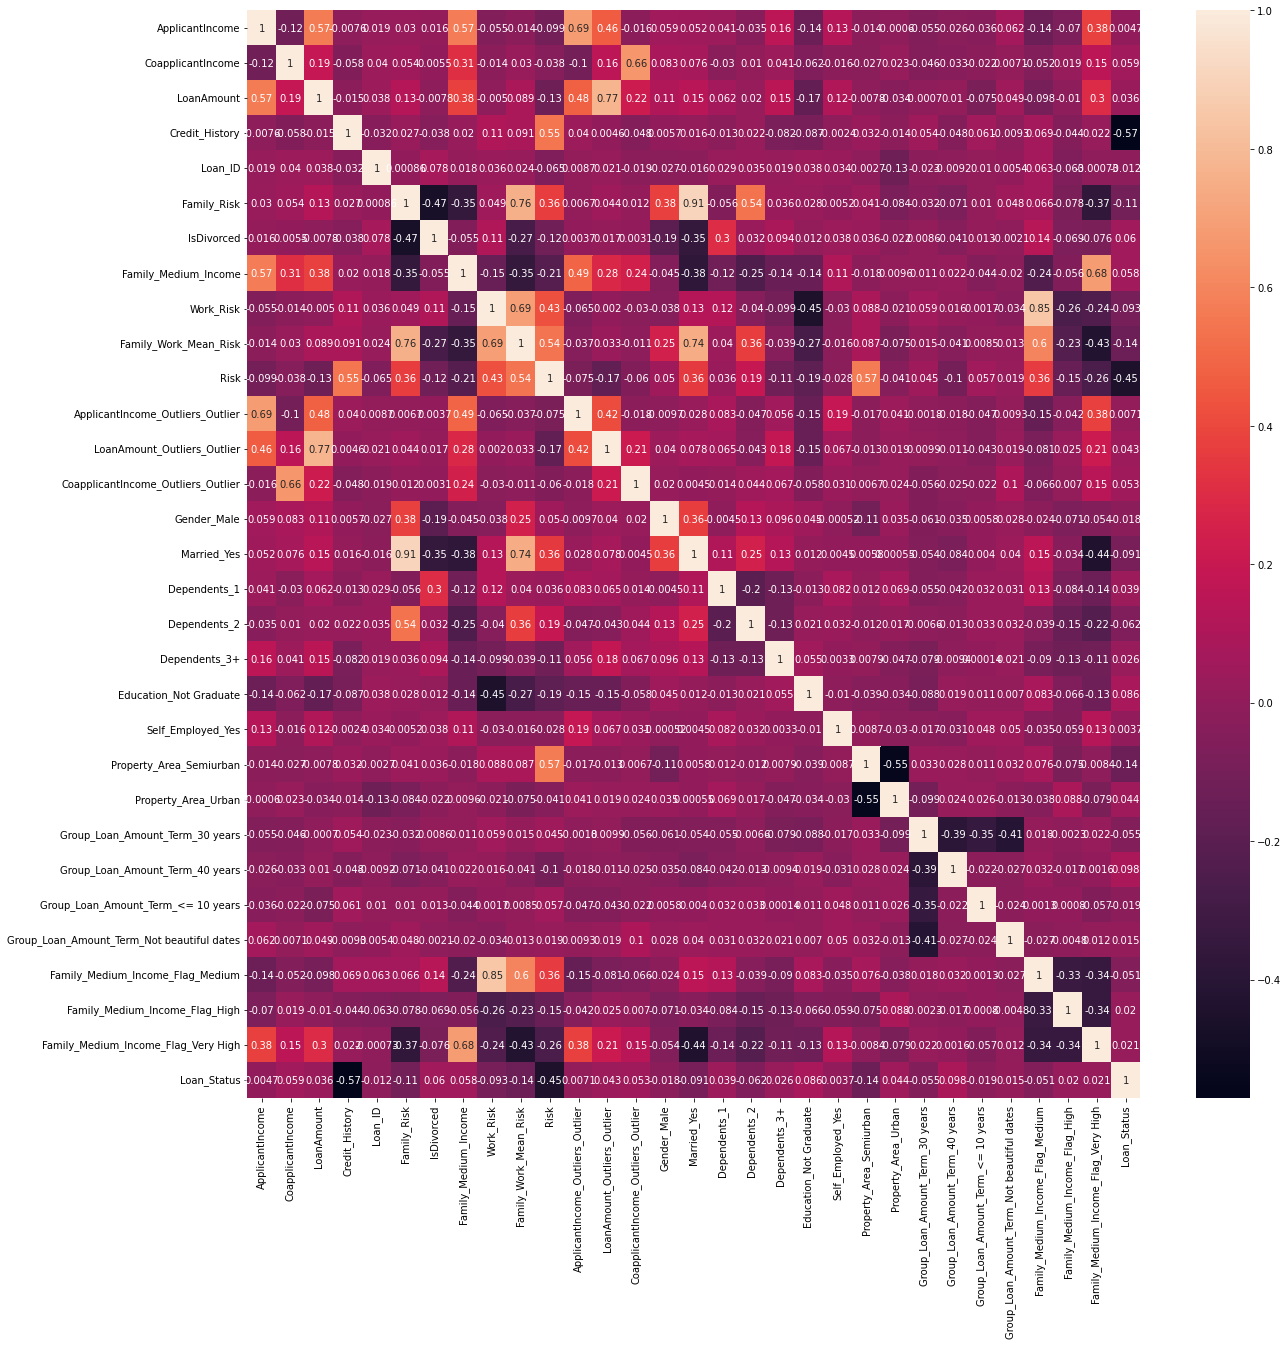

In [735]:
final_data_to_train_test = pd.concat([final_data.iloc[:idx, :], target.map({'Y': 0, 'N': 1})], axis=1)

plt.figure(figsize=(20, 20))
sns.heatmap(final_data_to_train_test.corr(), annot=True)

**PCA?**

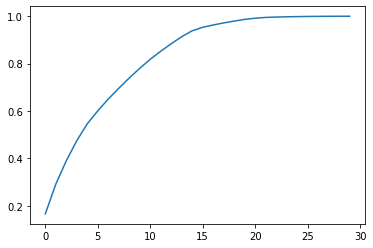

In [736]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(final_data)

plt.plot(np.cumsum(pca.explained_variance_ratio_))

In [ ]:
pca = PCA(n_components=8)
final_data_pca_tr = pd.DataFrame(data=pca.fit_transform(final_data))

**Most important features by heatmap** 

In [760]:
corr = final_data_to_train_test.corr()['Loan_Status']
feats = corr[np.abs(corr) >= 0.1].index[:-1]

final_data_important = final_data[feats]
len(feats)

5

**Формируем тренировочный / тестовый сет**

In [761]:
X_train, X_test, y_train, y_test = train_test_split(
        final_data_important.iloc[:idx, :], target.map({'Y': 0, 'N': 1}), 
        stratify=target.map({'Y': 0, 'N': 1}), test_size=0.2, 
        random_state=RS)

In [762]:
from lightgbm import LGBMClassifier
# from sklearn.ensemble import RandomForestClassifier

lgbm = LGBMClassifier(n_estimators=150, 
                        max_depth = 10,
                        max_features=7, 
                        random_state=RS)

lgbm.fit(final_data_important.iloc[:idx, :], target.map({'Y': 0, 'N': 1}))
# lgbm.fit(X_train, y_train)


print(lgbm.score(X_test, y_test))
print(lgbm.score(X_train, y_train))

# print(lgbm.oob_score)

0.8536585365853658
0.8329938900203666


In [763]:
print(confusion_matrix(y_test, lgbm.predict(X_test)))
print(classification_report(y_test, lgbm.predict(X_test)))

[[84  1]
 [17 21]]
              precision    recall  f1-score   support

           0       0.83      0.99      0.90        85
           1       0.95      0.55      0.70        38

    accuracy                           0.85       123
   macro avg       0.89      0.77      0.80       123
weighted avg       0.87      0.85      0.84       123



In [764]:
print(confusion_matrix(y_train, lgbm.predict(X_train)))
print(classification_report(y_train, lgbm.predict(X_train)))

[[330   7]
 [ 75  79]]
              precision    recall  f1-score   support

           0       0.81      0.98      0.89       337
           1       0.92      0.51      0.66       154

    accuracy                           0.83       491
   macro avg       0.87      0.75      0.77       491
weighted avg       0.85      0.83      0.82       491



In [765]:
# plt.figure(figsize=(70, 10))

# sns.barplot(final_data.columns, lgbm.feature_importances_)

Лог регрессия предсказывает настоящие нули с вероятностью 0.5...
Xa-xa-xa!

In [766]:
# lr_predict = lr.predict(final_data_pca_tr.iloc[idx:, :])

# lr_predict = np.where(lr_predict == 0, 'Y', lr_predict)
# lr_predict = np.where(lr_predict == 1, 'N', lr_predict)

In [767]:
lgbm_predict = lgbm.predict(final_data_important.iloc[idx:, :])

lgbm_predict = np.where(lgbm_predict == 0, 'Y', lgbm_predict)
lgbm_predict = np.where(lgbm_predict == '1', 'N', lgbm_predict)

In [768]:
sample_submission['Loan_Status'] = lgbm_predict

In [770]:
sample_submission.to_csv('sub2_28.csv', index=False)

In [ ]:
# train_tr.to_csv('Train_tr.csv', index=False)
# test_tr.to_csv('Test_tr.csv', index=False)

# target.to_csv('Target.csv', index=False)